In [1]:
!pip install gensim
!pip install --upgrade numpy
!pip install --upgrade gensim
!pip install --upgrade scipy
!pip uninstall numpy -y
!pip uninstall pandas -y
!pip uninstall xarray -y
!pip uninstall plotly -y
!pip uninstall gensim -y

!pip install gensim
!pip install numpy==1.26.0
!pip install scipy
!pip install pandas
!pip install plotly
!pip install xarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cmdstanpy 1.2.5 requires pandas, which is not installed.
statsmodels 0.14.4 requires pandas!=2.1.0,>=1.4, which is not installed.
sklearn-pandas 2.2.0 requires pandas>=1.1.4, which is not installed.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, which is not installed.
pymc 5.21.1 requires pandas>=0.24.0, which is not installed.
mizani 0.13.1 requires pandas>=2.2.0, which is not installed.
pandas-gbq 0.28.0 requires pandas>=1.1.4, which is not installed.
arviz 0.21.0 re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_fake = pd.read_csv('/content/drive/MyDrive/Fake/Fake.csv')
df_true = pd.read_csv('/content/drive/MyDrive/Fake/True.csv')
data = df_fake


In [4]:
data.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
import pandas as pd

# Add target labels to each dataset
df_true['target'] = 1  # True news
df_fake['target'] = 0  # Fake news

# Combine the datasets
df = pd.concat([df_true, df_fake]).reset_index(drop=True)

# Create a new 'original' column by combining 'title' and 'text'
df['original'] = df['title'] + ' ' + df['text']

# Count the number of true and false news articles
true_count = df[df['target'] == 1].shape[0]
false_count = df[df['target'] == 0].shape[0]

# Calculate the total number of articles
total_count = df.shape[0]

# Print the counts
print(f"Number of True news articles: {true_count}")
print(f"Number of Fake news articles: {false_count}")
print(f"Total number of news articles: {total_count}")

# Save the entire dataset to a CSV file
output_file_path = "/content/drive/My Drive/real/combined_dataset.csv"  # Replace with your desired path
df.to_csv(output_file_path, index=False)
print(f"Dataset saved to '{output_file_path}'")


Number of True news articles: 21417
Number of Fake news articles: 23481
Total number of news articles: 44898
Dataset saved to '/content/drive/My Drive/real/combined_dataset.csv'


In [6]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
target,0
original,0


In [7]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)

    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

In [9]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

<ipython-input-9-41457b5f018e>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
<ipython-input-9-41457b5f018e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origi

In [10]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

<ipython-input-10-158bb635d3aa>:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 r

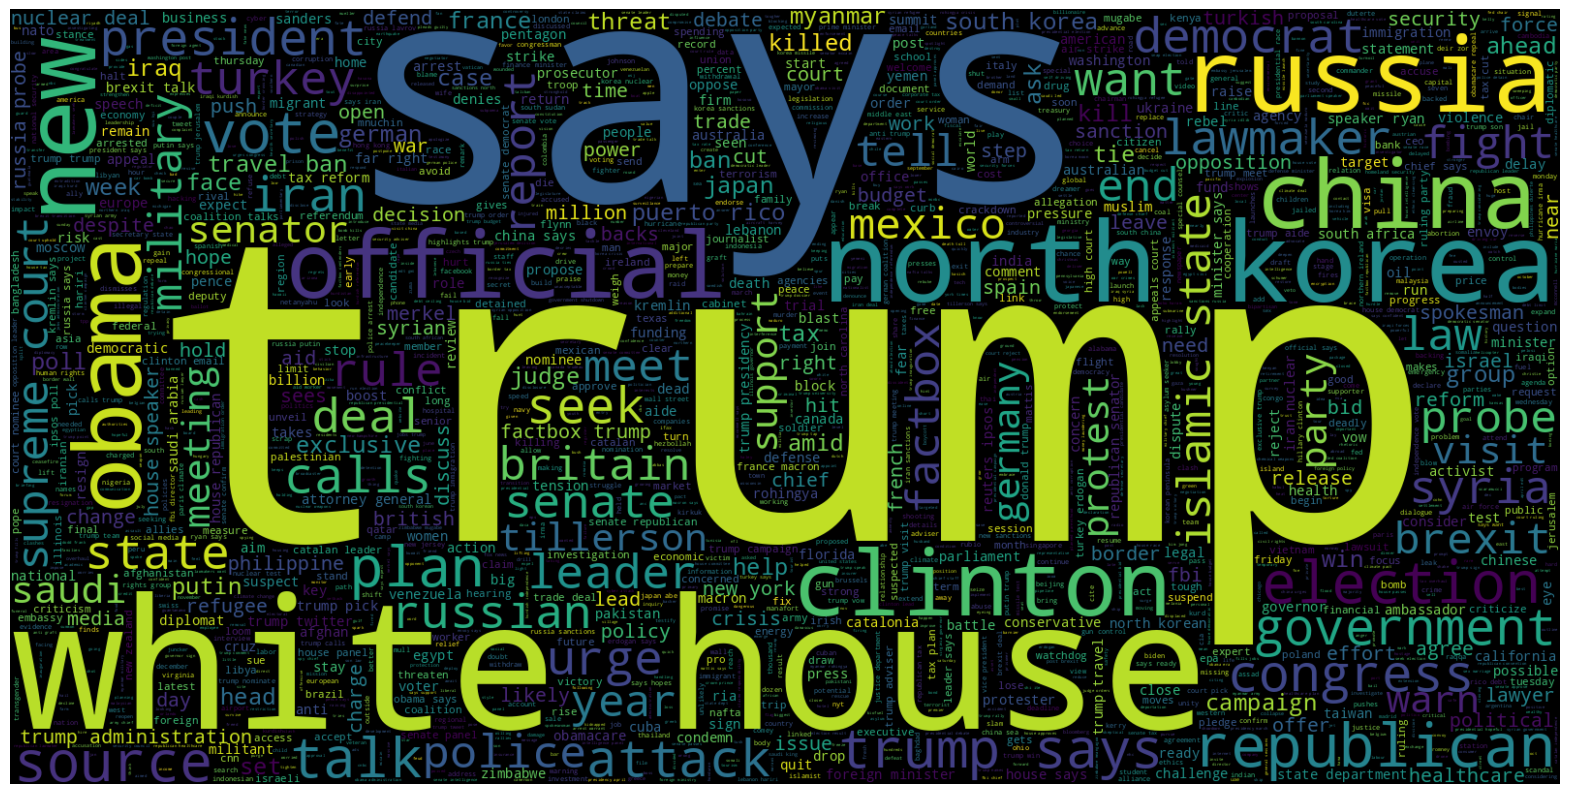

In [11]:
# Install necessary libraries
!pip install --upgrade numpy gensim scipy wordcloud matplotlib

# Import necessary libraries
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure 'df' is defined before applying transformations
# Assuming df['title'] exists and preprocess function is defined
df['clean_title'] = df['title'].apply(preprocess)

# Join tokenized words into a single string
df['clean_joined_title'] = df['clean_title'].apply(lambda x: " ".join(x))

# Define stopwords if not already defined
stop_words = set()  # Define your stopwords set if needed

# Generate word cloud for fake news (assuming target == 1 represents fake news)
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df[df['target'] == 1]['clean_joined_title']))

# Display the word cloud
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")  # Hide axis
plt.show()


In [12]:
import nltk

# Download the 'punkt_tab' data file
nltk.download('punkt_tab')
nltk.download('punkt')
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The maximum number of words in a title is = 34


In [13]:
df

,title,text,subject,date,target,original,clean_title,clean_joined_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,PoliticsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal script
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,PoliticsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,PoliticsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, let, mueller, job]",senior republican senator let mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,PoliticsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,"[fbi, russia, probe, helped, australian, diplo...",fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,PoliticsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailors
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls quits


In [14]:
import re
def wordopt(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df["text"] = df["text"].apply(wordopt)
df["id"] = df.index

In [15]:
x = df[["id", "text"]]  # Features (ID and text)
y = df["target"]  # Labels

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Step 5: Save the split datasets
train_data = pd.DataFrame({'id': x_train["id"], 'text': x_train["text"], 'target': y_train})
train_data.to_csv("/content/drive/My Drive/real/train_filtered.csv", index=False)

test_data = pd.DataFrame({'id': x_test["id"], 'text': x_test["text"], 'target': y_test})
test_data.to_csv("/content/drive/My Drive/real/test.csv", index=False)

# Step 6: Print success messages
print("train_filtered.csv saved successfully in Google Drive!")
print("test.csv saved successfully in Google Drive!")

# Optional: Display sample data to verify
print(train_data.head())

train_filtered.csv saved successfully in Google Drive!
test.csv saved successfully in Google Drive!
          id                                               text  target
13637  13637  UNITED NATIONS  Reuters    The United States a...       1
42421  42421  It s fascinating that even before any facts re...       0
37916  37916  Pathetic Predictably impotent  We are not unit...       0
3321    3321  WASHINGTON  Reuters    Aides to U S  President...       1
2345    2345   Reuters    Former FBI Director James Comey  w...       1


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split



# Ensure ID column exists (if dataset already has an ID column, use it)
df["id"] = df.index  # Creates an ID column from row indices if not already present

# Train-test split
x = df[["id", "text"]]  # Include ID in X
y = df["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Convert train data to DataFrame (keeping ID)
train_data = pd.DataFrame({'id': x_train["id"], 'text': x_train["text"], 'target': y_train})

# Save to Google Drive
train_data.to_csv("/content/drive/My Drive/real/train_filtered.csv", index=False)
test_data = pd.DataFrame({'id': x_test["id"], 'text': x_test["text"], 'target': y_test})
test_data.to_csv("/content/drive/My Drive/real/test.csv", index=False)
print("test.csv saved successfully in Google Drive!")


print("train.csv saved successfully in Google Drive!")

# Optional: Print sample data to verify ID inclusion
print(train_data.head())

test.csv saved successfully in Google Drive!
train.csv saved successfully in Google Drive!
          id                                               text  target
13637  13637  UNITED NATIONS  Reuters    The United States a...       1
42421  42421  It s fascinating that even before any facts re...       0
37916  37916  Pathetic Predictably impotent  We are not unit...       0
3321    3321  WASHINGTON  Reuters    Aides to U S  President...       1
2345    2345   Reuters    Former FBI Director James Comey  w...       1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initial Accuracy: 99.77%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5858
           1       1.00      1.00      1.00      5367

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



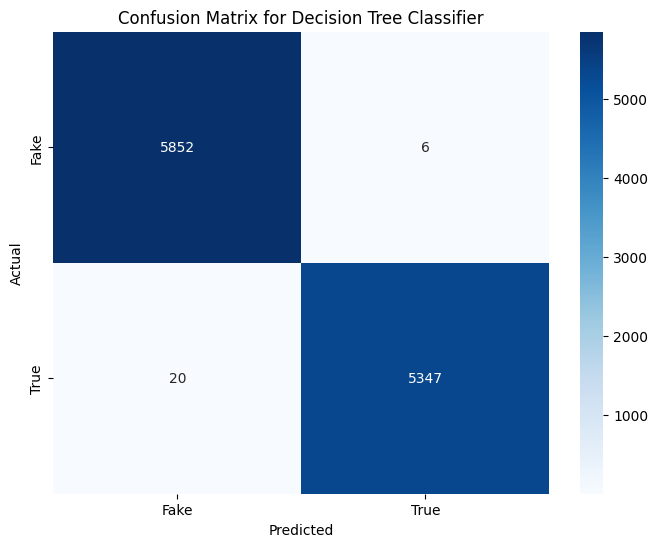

Cleaned misclassified data saved to /content/drive/My Drive/real/misclassified_data_cleaned.csv
Total Data Samples: 11225
Initial Correct Predictions: 11199
Total Misclassified Before Correction: 26
Number of Corrected Predictions: 5
Updated Accuracy After Rechecking: 99.81%
Re-predicted misclassified data saved to /content/drive/My Drive/real/misclassified_data_repredicted.csv


In [21]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load training data
train_data = pd.read_csv("/content/drive/My Drive/real/train_filtered.csv")

# Ensure column names are correct
if "text" not in train_data.columns or "target" not in train_data.columns:
    raise ValueError("Ensure 'text' and 'target' columns exist in train_filtered.csv")

# Separate features and target variable
x_train = train_data["text"]
y_train = train_data["target"]

# Load test data
df = pd.read_csv("/content/drive/My Drive/real/test.csv")  # Ensure test data is loaded properly

if "text" not in df.columns or "target" not in df.columns:
    raise ValueError("Ensure 'text' and 'target' columns exist in the test dataset")

x_test = df["text"]
y_test = df["target"]

# Step 1: Create and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Unigrams, bigrams, trigrams
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

# Step 2: Train Decision Tree Classifier
DT = DecisionTreeClassifier(random_state=42)
DT.fit(x_train_vec, y_train)

pred_dt = DT.predict(x_test_vec)

# Step 3: Compute Initial Accuracy
correct_predictions = (pred_dt == y_test).sum()
initial_accuracy = (correct_predictions / len(y_test)) * 100
print(f"Initial Accuracy: {initial_accuracy:.2f}%")

# Step 4: Classification Report
print("Classification Report:")
print(classification_report(y_test, pred_dt))

# Step 5: Confusion Matrix
confusion_mat = confusion_matrix(y_test, pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

# Step 6: Identify Misclassified Samples
misclassified_indices = (pred_dt != y_test)
misclassified_samples = y_test.index[misclassified_indices]

# Create a DataFrame for misclassified samples
misclassified_data = pd.DataFrame({
    'ID': misclassified_samples.values,
    'Actual': y_test.loc[misclassified_indices].values,
    'Predicted': pred_dt[misclassified_indices],
    'Text': x_test.loc[misclassified_indices].values
})

# Function to remove stopwords
def remove_stopwords(text):
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Step 7: Clean Misclassified Samples
misclassified_data['Text_Cleaned'] = misclassified_data['Text'].apply(remove_stopwords)

# Step 8: Remove Short Texts (< 50 characters)
misclassified_data = misclassified_data[misclassified_data['Text_Cleaned'].apply(len) > 50]

# Step 9: Save Cleaned Misclassified Data
cleaned_output_path = "/content/drive/My Drive/real/misclassified_data_cleaned.csv"
misclassified_data.to_csv(cleaned_output_path, index=False)
print(f"Cleaned misclassified data saved to {cleaned_output_path}")

# Step 10: Re-predict on Cleaned Misclassified Text
X_misclassified_transformed = vectorizer.transform(misclassified_data['Text_Cleaned'])
new_predictions = DT.predict(X_misclassified_transformed)

# Step 11: Compare and Save Results
misclassified_data['New_Predicted'] = new_predictions

# Step 12: Check How Many Were Corrected
corrected = (misclassified_data['New_Predicted'] == misclassified_data['Actual']).sum()
total_misclassified = len(misclassified_data)

# Debugging print statements
print(f"Total Data Samples: {len(y_test)}")
print(f"Initial Correct Predictions: {correct_predictions}")
print(f"Total Misclassified Before Correction: {total_misclassified}")
print(f"Number of Corrected Predictions: {corrected}")

# Step 13: Recalculate Accuracy After Correction
new_correct_predictions = correct_predictions + corrected
updated_accuracy = (new_correct_predictions / len(y_test)) * 100

print(f"Updated Accuracy After Rechecking: {updated_accuracy:.2f}%")

# Step 14: Save Re-Predicted Results
re_predicted_output_path = "/content/drive/My Drive/real/misclassified_data_repredicted.csv"
misclassified_data.to_csv(re_predicted_output_path, index=False)
print(f"Re-predicted misclassified data saved to {re_predicted_output_path}")


In [19]:
import pickle

with open("/content/drive/My Drive/real/DT_model.pkl", "wb") as file:
    pickle.dump(DT, file)



print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


In [20]:
import pickle

with open("/content/drive/My Drive/real/vectorizer_model.pkl", "wb") as f:
    pickle.dump(vectorizer, f)